#Zadanie 7 (7 pkt)
Celem zadania jest zaimplementowanie dwóch wersji naiwnego klasyfikatora Bayesa.
* W pierwszej wersji należy dokonać dyskretyzacji danych - przedział wartości każdego atrybutu dzielimy na cztery równe przedziały i każdej ciągłej wartości atrybutu przypisujemy wartość dyskretną wynikająca z przynależności do danego przedziału.
* W drugiej wersji wartości likelihood wyliczamy z rozkładów normalnych o średnich i odchyleniach standardowych wynikających z wartości atrybutów.
Trening i test należy przeprowadzić dla zbioru Iris, tak jak w przypadku zadania z drzewem klasyfikacyjnym. Proszę przeprowadzić eksperymenty najpierw dla DOKŁADNIE takiego podziału zbioru testowego i treningowego jak umieszczony poniżej. W dalszej części należy przeprowadzić analizę działania klasyfikatorów dla różnych wartości parametrów. Proszę korzystać z przygotowanego szkieletu programu, oczywiście można go modyfikować według potrzeb. Wszelkie elementy szkieletu zostaną wyjaśnione na zajęciach.

* Dyskretyzacja danych - **0.5 pkt**
* Implementacja funkcji rozkładu normalnego o zadanej średniej i odchyleniu standardowym. - **0.5 pkt**
* Implementacja naiwnego klasyfikatora Bayesa dla danych dyskretnych. - **2.0 pkt**
* Implementacja naiwnego klasyfikatora Bayesa dla danych ciągłych. - **2.5 pkt**
* Przeprowadzenie eksperymentów, wnioski i sposób ich prezentacji. - **1.5 pkt**


In [64]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import math
from collections import Counter
import numpy as np
from matplotlib import pyplot as plt

iris = load_iris()

x = iris.data
y = iris.target

In [65]:
class NaiveBayes:
    def __init__(self):
        self.priors = {}
        self.likelihoods = {}
        self.boundaries = {}

    def build_classifier(self, train_features, train_classes):
        discrete = self.data_discretization(train_features)
        counterCl = Counter(train_classes)

        for cl in counterCl:
            self.priors[cl] = counterCl[cl] / len(train_classes)
            self.likelihoods[cl] = {}
            class_data = [discrete[i] for i in range(len(train_classes)) if train_classes[i] == cl]
            
            for i in range(train_features.shape[1]):  
                feature_vals = [sample[i] for sample in class_data] 
                class_counter = Counter(feature_vals)
            
                for val in class_counter:
                    self.likelihoods[cl][val] = class_counter[val] / counterCl[cl]

    def data_discretization(self, data):
        percentiles = [25, 50, 75]
        data_copy = data.copy()
        for col in range(data_copy.shape[1]):
            if col not in self.boundaries:
                self.boundaries[col] = np.percentile(data[:, col], percentiles)
            boundaries = self.boundaries[col]
            
            for i in range(data_copy.shape[0]):
                val = data_copy[i, col]
                if val <= boundaries[0]:
                    data_copy[i, col] = 1
                elif val <= boundaries[1]:
                    data_copy[i, col] = 2
                elif val <= boundaries[2]:
                    data_copy[i, col] = 3
                else:
                    data_copy[i, col] = 4
        return data_copy     

    def predict(self, sample):
        disc_sample = self.data_discretization(np.array(sample)[np.newaxis, :])
        max_prob = -1 
        predicted_class = None 

        for cl in self.priors:
            prob = self.priors[cl]  

            for feature_val in disc_sample[0]:  
                if feature_val in self.likelihoods[cl]:
                    prob *= self.likelihoods[cl][feature_val]
                else:
                    prob *= 0

            if prob > max_prob:
                max_prob = prob
                predicted_class = cl

        return predicted_class

class GaussianNaiveBayes:
    def __init__(self):
        self.priors = {}
        self.likelihoods = {}

    def build_classifier(self, train_features, train_classes):
        counterCl = Counter(train_classes)

        for cl in counterCl:
            self.priors[cl] = counterCl[cl] / len(train_classes)
            self.likelihoods[cl] = {}
            class_data = [train_features[i] for i in range(len(train_classes)) if train_classes[i] == cl] 

            class_data = np.array(class_data)
            mean = np.mean(class_data, axis=0)  
            std = np.std(class_data, axis=0)

            for col in range(class_data.shape[1]):
                self.likelihoods[cl][col] = (mean[col], std[col])

    @staticmethod
    def normal_dist(x, mean, std):
        if std == 0:  
            return 1
        normal = (1 / math.sqrt(2 * math.pi * (std ** 2))) * (math.e ** (-(((x - mean) ** 2) / (2 * (std ** 2)))))
        return normal

    def predict(self, sample):
        max_prob = -1 
        predicted_class = None 

        for cl in self.priors:
            prob = self.priors[cl]  

            for col, feature_val in enumerate(sample):
                mean, std = self.likelihoods[cl][col]
                prob *= self.normal_dist(feature_val, mean, std)

            if prob > max_prob:
                max_prob = prob
                predicted_class = cl

        return predicted_class

Accuracy for discretization for random_state=123: 0.8
Accuracy for normal distribution for random_state=123: 1.0


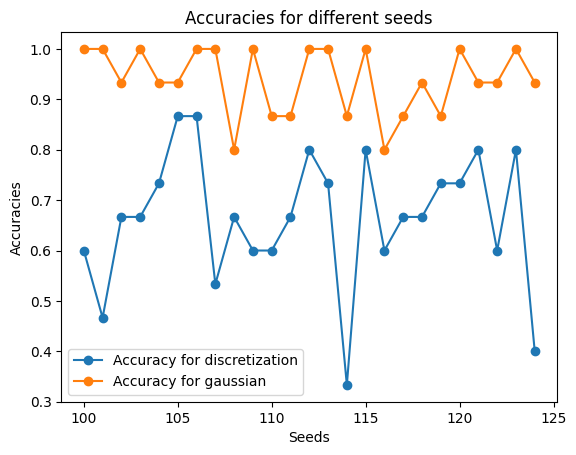

In [66]:
seeds = []
discretes = []
gaussians = []

for seed in range(100, 125):
    seeds.append(seed)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=seed)
    nb = NaiveBayes()
    nb.build_classifier(x_train, y_train)
    correct_predictions = 0
    for sample, gt in zip(x_test, y_test):
        prediction = nb.predict(sample)
        if(prediction == gt):
            correct_predictions+=1
    accuracy = correct_predictions/len(y_test)
    if seed==123:
        print(f"Accuracy for discretization for random_state=123: {accuracy}")
    discretes.append(accuracy)

    gnb = GaussianNaiveBayes()
    gnb.build_classifier(x_train, y_train)
    correct_predictions = 0
    for sample, gt in zip(x_test, y_test):
        prediction = gnb.predict(sample)
        if(prediction == gt):
            correct_predictions+=1
    accuracy = correct_predictions/len(y_test)
    if seed==123:
        print(f"Accuracy for normal distribution for random_state=123: {accuracy}")
    gaussians.append(accuracy)

plt.plot(seeds, discretes, label="Accuracy for discretization", marker='o')
plt.plot(seeds, gaussians, label="Accuracy for gaussian", marker='o')
plt.xlabel("Seeds")
plt.ylabel("Accuracies")
plt.title(f"Accuracies for different seeds")
plt.legend()
plt.show()

- Accuracy dla dystrybucji ciągłej (gaussian) jest zawsze większa, osiągając czasami wartość 100% oraz posiada mniejszą amplitudę wartości, najmniejsza dokładność to tylko aż 80%.
- Accuracy dla dyskretyzacji jest o wiele bardziej niestabilne, czasami daje radę osiągnąć wartości bliskie 90%, ale też tak niskie jak lekko ponad 30%.
- Można więc stwierdzić, że wartości dyskretne są gorszym wyborem do nauczenia programu, szczególnie jak rozbijamy tylko na 4 przedziały.